<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#Модель-логистической-регрессии" data-toc-modified-id="Модель-логистической-регрессии-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель логистической регрессии</a></span></li><li><span><a href="#Модель-на-основе-решающего-дерева" data-toc-modified-id="Модель-на-основе-решающего-дерева-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Модель на основе решающего дерева</a></span></li><li><span><a href="#Модель-на-основе-случайного-леса" data-toc-modified-id="Модель-на-основе-случайного-леса-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Модель на основе случайного леса</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Увеличение выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
# В проекте будем решать задачу классификации. Загрузим библиотеки, которые будут использоваться
import pandas as pd
import numpy as np # Для создания нецелочисленных последовательностей
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Для разбиения данных на выборки
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Для масштабирования и прямого кодирования признаков
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle # Для перемешивания данных при расширении набора данных
from sklearn.metrics import (
    recall_score, 
    f1_score,            # Расчёт F1-меры
    roc_auc_score,        # Расчёт AUC ROC
    roc_curve            # Построение ROC-кривой
)

# Константа для random_state
RANDOM_STATE = 12345

In [2]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [3]:
# Рассмотрим первые строки
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Каждый объект в наборе данных — это информация о клиенте банка.
Столбцы содержат следующую информацию (признаки):    
- `RowNumber` — индекс строки в данных,
- `CustomerId` — уникальный идентификатор клиента,
- `Surname` — фамилия,
- `CreditScore` — кредитный рейтинг,
- `Geography` — страна проживания,
- `Gender` — пол,
- `Age` — возраст,
- `Tenure` — сколько лет человек является клиентом банка,
- `Balance` — баланс на счёте,
- `NumOfProducts` — количество продуктов банка, используемых клиентом,
- `HasCrCard` — наличие кредитной карты,
- `IsActiveMember` — активность клиента,
- `EstimatedSalary` — предполагаемая зарплата,
- `Exited` — факт ухода клиента.

Целевой признак - `Exited`.

In [4]:
# Изучим информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# Посчитаем пропуски
df.isna().sum()/df.shape[0]

RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

Как видим, в дата сете в столбце `Tenure` имеются пропуски в объёме 9,09%.

In [6]:
# Рассмотрим уникальные значения в столбце
df['Tenure'].value_counts(dropna=False)

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
NaN     909
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

Как видим, в столбце представлен диапазон от 0 до 10 лет, т.е. клиенты банка сотрудничают с ним либо меньше года, либо более длительный срок, но не более 10 лет. Полученная информация не даёт оснований для заполнения пропусков какими-либо данными.

In [7]:
# Посмотрим часть объектов, у которых признак Tenure не определён
df[df['Tenure'].isna()].sample(25)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9925,9926,15605672,Yuan,694,France,Female,38,NaN,195926.39,1,1,1,85522.84,0
8289,8290,15625023,Onochie,682,France,Male,40,NaN,0.00,1,0,1,105352.55,0
7028,7029,15618410,Murray,718,Germany,Male,26,NaN,147527.03,1,0,0,51099.56,0
7351,7352,15568878,Cheng,654,Spain,Male,34,NaN,0.00,2,1,0,159311.46,0
8739,8740,15615219,Obielumani,518,France,Male,59,NaN,138772.15,1,0,1,123872.00,0
1059,1060,15812197,Kline,850,France,Male,38,NaN,80293.98,1,0,0,126555.74,0
4319,4320,15759456,Lupton,609,Spain,Male,34,NaN,140694.78,2,1,0,46266.63,0
2619,2620,15800062,Lanford,850,Spain,Male,49,NaN,0.00,1,0,0,25867.67,1
4974,4975,15744942,Steele,638,Spain,Female,55,NaN,155828.22,1,0,1,108987.25,1
8536,8537,15676576,Stephenson,646,France,Female,43,NaN,143061.88,1,1,0,61937.60,0


Как видим, признак не определён для разнообразных объектов: и для объектов с нулевым счётом, и с ненулевым, для покинувших банк, и для не покинувших. Имеющаяся информация не позволяет достоверно определить значение признака `Tenure`. Можно попытаться восстановить значение признака путём обучения модели с целевым признаком `Tenure`, но делать этого не будем, т.к. во-первых, имеющихся данных о 9091 объектах достаточно для обучения и проверки модели для целевого признака `Exited`, а во-вторых, при обучении модели на целевой признак `Tenure` нам пришлось бы использовать целевой признак в качестве простого признака, что может привести к переобученности модели с целевым признаком `Exited`. Таким образом, удаляем данные с пропусками.

In [8]:
df = df[~(df['Tenure'].isna())].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [9]:
# Проверим на наличие дубликатов
df.duplicated().sum()

0

Столбцы RowNumber, CustomerId, Surname не несут в себе ценныой информации с точки зрения предсказания целевого признака. Это случайные параметры, которые просто идентифицируют клиента, но ничего не позволяют сказать о его поведении. Удалим указанные столбцы.

In [10]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


In [11]:
# Для дальнейшей работы составим список столбцов с числовыми данными
numeric=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [12]:
# Рассмотрим данные числовых столбцов
df[numeric].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000,9091.000000
mean,650.736553,38.949181,4.997690,76522.740015,1.530195,100181.214924
std,96.410471,10.555581,2.894723,62329.528576,0.581003,57624.755647
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,51227.745000
50%,652.000000,37.000000,5.000000,97318.250000,1.000000,100240.200000
75%,717.000000,44.000000,7.000000,127561.890000,2.000000,149567.210000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


Все числовые данные не выглядят аномальными. Рассмотрим оставшиеся столбцы.

In [13]:
df['Geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: Geography, dtype: int64

In [14]:
df['Gender'].value_counts()

Male      4974
Female    4117
Name: Gender, dtype: int64

In [15]:
df['HasCrCard'].value_counts()

1    6409
0    2682
Name: HasCrCard, dtype: int64

In [16]:
df['IsActiveMember'].value_counts()

1    4687
0    4404
Name: IsActiveMember, dtype: int64

Так как модели не работают с категориальными переменными, для обеспечения возможности обучения модели выполним прямое кодирование категориальных признаков. Коме того, учитывя большую разницу в масштабах значений числовых признаков, выполним масштабирование числовых признаков.

Подготовим выборки: обучаюшую, валидационную и тестовую. Соотношение мощностей выборок будет 60:20:20.

In [17]:
target = df['Exited']
features = df.drop('Exited', axis=1)
features_train, features_validtest, target_train, target_validtest = train_test_split(
    features, target, test_size=0.4, random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_validtest, target_validtest, test_size=0.5, random_state=RANDOM_STATE)

In [18]:
print('Размер выборок:')
print('общий ', df.shape[0], ',', sep='')
print('обучающая ', features_train.shape[0], ',', sep='')
print('валидационная ', features_valid.shape[0], ',', sep='')
print('тестовая ', features_test.shape[0], '.', sep='')

Размер выборок:
общий 9091,
обучающая 5454,
валидационная 1818,
тестовая 1819.


Выполним прямое кодирование категориальных переменных

In [19]:
# Составим список признаков для прямого кодирования
features_ohe = df.select_dtypes(include='object').columns.to_list()
features_ohe

['Geography', 'Gender']

In [20]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[features_ohe])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_ohe = features_train.copy()
features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[features_ohe])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(features_ohe, axis=1)

# Аналогичные преобразования с подготовленным на обучающей выборке энкодером выполним для валидационной и тестовой выборки
# Валидационная
features_valid_ohe = features_valid.copy()
features_valid_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid_ohe[features_ohe])
features_valid_ohe = features_valid_ohe.drop(features_ohe, axis=1)

# Тестовая
features_test_ohe = features_test.copy()
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[features_ohe])
features_test_ohe = features_test_ohe.drop(features_ohe, axis=1)

In [21]:
# Выполним масштабирование числовых признаков
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train_ohe_scaled = features_train_ohe.copy()
features_train_ohe_scaled[numeric] = scaler.transform(features_train_ohe_scaled[numeric])

# C подготовленным на обучающей выборке скалером выполним масштабирование признаков валидационной и тестовой выборок
# Валидационная
features_valid_ohe_scaled = features_valid_ohe.copy()
features_valid_ohe_scaled[numeric] = scaler.transform(features_valid_ohe_scaled[numeric])

# Тестовая
features_test_ohe_scaled = features_test_ohe.copy()
features_test_ohe_scaled[numeric] = scaler.transform(features_test_ohe_scaled[numeric])

In [22]:
# Посмотрим первые строки выборок после преобразований
display (features_train_ohe_scaled.head())
display (features_valid_ohe_scaled.head())
features_test_ohe_scaled.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9344,0.809075,-1.039327,-1.025995,0.554904,-0.908179,1,0,0.019508,0.0,0.0,0.0
3796,-1.152518,-1.227561,0.696524,0.480609,-0.908179,0,0,0.056167,0.0,0.0,1.0
7462,-0.398853,0.090079,1.385532,-1.237830,-0.908179,1,1,0.848738,0.0,0.0,1.0
1508,-0.749875,-0.286389,0.352020,-1.237830,0.809300,1,1,-0.894953,0.0,0.0,1.0
4478,-1.028628,-0.756975,-0.336987,-1.237830,0.809300,0,1,-1.284516,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7445,-1.369326,0.560665,-0.336987,-1.237830,-0.908179,1,0,-0.086537,0.0,0.0,0.0
8620,1.232367,0.090079,1.041028,-1.237830,0.809300,0,1,-0.537457,0.0,0.0,0.0
1714,0.840048,0.560665,0.352020,1.231363,-0.908179,0,0,1.070393,1.0,0.0,1.0
5441,1.056856,-0.945210,-1.370498,0.951231,-0.908179,1,0,-0.576279,0.0,0.0,1.0
9001,0.406433,-0.662858,0.352020,0.767800,-0.908179,1,1,0.662068,0.0,1.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5170,1.707279,-0.756975,-0.336987,-1.237830,0.809300,1,1,0.718362,0.0,0.0,0.0
4180,-0.429826,-0.286389,1.730036,0.485538,0.809300,0,0,1.687305,1.0,0.0,1.0
7349,-0.171721,0.278313,0.352020,-0.269213,0.809300,0,1,0.824128,1.0,0.0,1.0
7469,0.385784,-0.380507,1.041028,0.464813,-0.908179,1,0,-1.118018,0.0,0.0,0.0
3467,-1.142194,0.278313,-1.370498,0.353837,0.809300,0,1,-0.107642,1.0,0.0,0.0


Выводы по этапу подготовки данных:
- рассмотрены данные, представленные в датасете,
- удалены пропуски, которые восстановить достоверно невозможно,
- удалены признаки, не представляющие интерес с точки зрения целевого признака,
- подготовлены обучающая, валидационная и тестовая выборки,
- выполнено прямое кодирование категориальных признаков,
- выполнено масштабирование числовых признаков.

## Исследование задачи

### Баланс классов

In [23]:
# Баланс классов в исходном датасете (среднее значение целевого признака покажет долю положительного класса)
df['Exited'].mean()

0.2039379606203938

In [24]:
# Баланс классов в выборках
print('обучающая ', round(target_train.mean(), 3), ',', sep='')
print('валидационная ', round(target_valid.mean(), 3), ',', sep='')
print('тестовая ', round(target_test.mean(), 3), ',', sep='')

обучающая 0.206,
валидационная 0.207,
тестовая 0.193,


Как видим, в  выборке имеется дисбаланс классов: представителей положительного класса ~20%.При этом баланс при создании выборок не был значительно нарушен. Изучим модели классификации без учёта небаланса.

### Модель логистической регрессии

In [25]:
# Обучим модель логистической регресии и проверим значение F1-меры на валидационной выборке
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train_ohe_scaled, target_train)
predicted_logreg_valid = model.predict(features_valid_ohe_scaled)
print('F1-мера:', round(f1_score(target_valid, predicted_logreg_valid), 3))
probabilities_logreg_valid = model.predict_proba(features_valid_ohe_scaled)
probabilities_one_valid = probabilities_logreg_valid[:, 1]
print('Площадь под ROC-кривой:', round(roc_auc_score(target_valid, probabilities_one_valid), 3))

F1-мера: 0.304
Площадь под ROC-кривой: 0.774


### Модель на основе решающего дерева

Для выбора наилучшей модели рассчитаем метрики качества модели при разных значениях максимальной глубины дерева в диапазоне от 2 до 10

In [26]:
best_model_tree = None
best_f1_tree = 0
best_auc_roc_tree = 0
best_max_depth_tree = 0
for depth in range(2, 11):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_train_ohe_scaled, target_train) # обучим модель на обучающей выборке
    predicted_tree_valid = model.predict(features_valid_ohe_scaled)
    result_f1 = f1_score(target_valid, predicted_tree_valid) # посчитаем качество модели на валидационной выборке
    probabilities_tree_valid = model.predict_proba(features_valid_ohe_scaled)
    probabilities_one_valid = probabilities_tree_valid[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
    if result_f1 > best_f1_tree and result_auc_roc > best_auc_roc_tree:
        best_model_tree = model # сохраним наилучшую модель
        best_f1_tree = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
        best_auc_roc_tree = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
        best_max_depth_tree = depth
print("F1-мера наилучшей модели на основе дерева на валидационной выборке:", round(best_f1_tree, 3))
print("AUC ROC наилучшей модели на основе дерева на валидационной выборке:", round(best_auc_roc_tree, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_tree)

F1-мера наилучшей модели на основе дерева на валидационной выборке: 0.561
AUC ROC наилучшей модели на основе дерева на валидационной выборке: 0.85
Параметр max_depth у наилучшей модели 6


### Модель на основе случайного леса

Для выбора наилучшей модели рассчитаем качество модели при разных значениях максимальной глубины дерева в диапазоне от 2 до 10 и количества деревьев в диапазоне от 5 до 100 c шагом 5

In [27]:
best_model_forest = None
best_f1_forest = 0
best_auc_roc_forest = 0
best_max_depth_forest = 0
best_n_estimators_forest = 0
for est in range(5, 101, 5):
    # print('estimators =', est)
    for depth in range(2, 11):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        model.fit(features_train_ohe_scaled, target_train) # обучим модель на обучающей выборке
        predicted_forest_valid = model.predict(features_valid_ohe_scaled)
        result_f1 = f1_score(target_valid, predicted_forest_valid) # посчитаем качество модели на валидационной выборке
        probabilities_forest_valid = model.predict_proba(features_valid_ohe_scaled)
        probabilities_one_valid = probabilities_forest_valid[:, 1]
        result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
        if result_f1 > best_f1_forest and result_auc_roc > best_auc_roc_forest:
            best_model_forest = model # сохраним наилучшую модель
            best_f1_forest = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
            best_auc_roc_forest = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
            best_max_depth_forest = depth
            best_n_estimators_forest = est
print("F1-мера наилучшей модели на основе случайного леса на валидационной выборке:", round(best_f1_forest, 3))
print("AUC ROC наилучшей модели на основе случайного леса на валидационной выборке:", round(best_auc_roc_forest, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_forest)
print("Параметр n_estimators у наилучшей модели", best_n_estimators_forest)

F1-мера наилучшей модели на основе случайного леса на валидационной выборке: 0.569
AUC ROC наилучшей модели на основе случайного леса на валидационной выборке: 0.872
Параметр max_depth у наилучшей модели 8
Параметр n_estimators у наилучшей модели 35


Результаты и гиперпараметры различных моделей без учёта баланса классов:
- модель линейной регрессии - f1-мера 0,304, площадь под ROC кривой 0,774,
- модель решающего дерева f1-мера 0,561, площадь под ROC кривой 0,85 (максимальная глубина 6),
- модель случайного леса f1-мера 0,569, площадь под ROC кривой 0,872 (число деревьев 35, максимальная глубина 8).

Ни одна из применённых моделей не позволила добиться требуемого значения целевой метрики качества.
Наихудшие показатели у модели на основе линейной регрессии, наилучшие - у модели на основе случайного леса.
Примем меры по борьбе с дисбалансом классов.

## Борьба с дисбалансом

### Взвешивание классов

In [28]:
# Обучим модель логистической регресии со взвешиванием классов и проверим качество на валидационной выборке
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
model.fit(features_train_ohe_scaled, target_train)
predicted_logreg_valid = model.predict(features_valid_ohe_scaled)
print('F1-мера:', round(f1_score(target_valid, predicted_logreg_valid), 3))
probabilities_logreg_valid = model.predict_proba(features_valid_ohe_scaled)
probabilities_one_valid = probabilities_tree_valid[:, 1]
print('Площадь под ROC-кривой:', round(roc_auc_score(target_valid, probabilities_one_valid), 3))

F1-мера: 0.51
Площадь под ROC-кривой: 0.757


In [29]:
# Перебирая параметр максимальной глубины, выберем модель на основе решающего дерева со
# взвешиванием классов, обеспечивающую максимальные показатели качества на валидационной выборке
best_model_tree = None
best_f1_tree = 0
best_auc_roc_tree = 0
best_max_depth_tree = 0
for depth in range(2, 11):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, class_weight='balanced')
    model.fit(features_train_ohe_scaled, target_train) # обучим модель на обучающей выборке
    predicted_tree_valid = model.predict(features_valid_ohe_scaled)
    result_f1 = f1_score(target_valid, predicted_tree_valid) # посчитаем качество модели на валидационной выборке
    probabilities_tree_valid = model.predict_proba(features_valid_ohe_scaled)
    probabilities_one_valid = probabilities_tree_valid[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
    if result_f1 > best_f1_tree and result_auc_roc > best_auc_roc_tree:
        best_model_tree = model # сохраним наилучшую модель
        best_f1_tree = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
        best_auc_roc_tree = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
        best_max_depth_tree = depth
print("F1-мера наилучшей модели на основе дерева на валидационной выборке:", round(best_f1_tree, 3))
print("AUC ROC наилучшей модели на основе дерева на валидационной выборке:", round(best_auc_roc_tree, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_tree)

F1-мера наилучшей модели на основе дерева на валидационной выборке: 0.574
AUC ROC наилучшей модели на основе дерева на валидационной выборке: 0.84
Параметр max_depth у наилучшей модели 5


In [30]:
# Перебирая параметры количества деревьев и максимальной глубины, выберем модель на основе случайного леса
# со взвешиванием классов, обеспечивающую максимальные показатели качества на валидационной выборке
best_model_forest = None
best_f1_forest = 0
best_auc_roc_forest = 0
best_max_depth_forest = 0
best_n_estimators_forest = 0
for est in range(5, 101, 5):
    # print('estimators =', est)
    for depth in range(2, 11):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est,
                                       max_depth=depth, class_weight='balanced')
        model.fit(features_train_ohe_scaled, target_train) # обучим модель на обучающей выборке
        predicted_forest_valid = model.predict(features_valid_ohe_scaled)
        result_f1 = f1_score(target_valid, predicted_forest_valid) # посчитаем качество модели на валидационной выборке
        probabilities_forest_valid = model.predict_proba(features_valid_ohe_scaled)
        probabilities_one_valid = probabilities_forest_valid[:, 1]
        result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
        if result_f1 > best_f1_forest and result_auc_roc > best_auc_roc_forest:
            best_model_forest = model # сохраним наилучшую модель
            best_f1_forest = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
            best_auc_roc_forest = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
            best_max_depth_forest = depth
            best_n_estimators_forest = est
print("F1-мера наилучшей модели на основе случайного леса на валидационной выборке:", round(best_f1_forest, 3))
print("AUC ROC наилучшей модели на основе случайного леса на валидационной выборке:", round(best_auc_roc_forest, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_forest)
print("Параметр n_estimators у наилучшей модели", best_n_estimators_forest)

F1-мера наилучшей модели на основе случайного леса на валидационной выборке: 0.644
AUC ROC наилучшей модели на основе случайного леса на валидационной выборке: 0.869
Параметр max_depth у наилучшей модели 9
Параметр n_estimators у наилучшей модели 30


Результаты и гиперпараметры различных моделей при использовании взвешивания классов:
- модель линейной регрессии - F1-мера 0,51, площадь под ROC кривой 0,757,
- модель решающего дерева F1-мера 0,574, площадь под ROC кривой 0,84 (максимальная глубина 5),
- модель случайного леса F1-мера 0,644, площадь под ROC кривой 0,869 (число деревьев 30, максимальная глубина 9).

Видим заметный рост качества у модели логистической регрессии и модели на основе случайного леса, а также незначительное улучшение у модели на основе решающего дерева. При этом снова модель на основе случайного леса позволила добиться требуемого значения целевой метрики качества.
Наихудшие показатели снова у модели на основе линейной регрессии, наилучшие - у модели на основе случайного леса.
Исследуем модели с применением других мер по борьбе с дисбалансом классов.

### Увеличение выборки

In [31]:
# Определим функцию, добавляющую в обучающую выборку объекты положительного класса и перемешивающую выборку
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

In [32]:
# Добавим в обучающую выборку объектов положительного класса в количестве, обеспечивающем баланс классов
features_upsampled, target_upsampled = upsample(features_train_ohe_scaled, target_train, 4)

In [33]:
# Обучим модель логистической регресии на расширенной выборке и проверим качество на валидационной выборке
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_logreg_valid = model.predict(features_valid_ohe_scaled)
print('F1-мера:', round(f1_score(target_valid, predicted_logreg_valid), 3))
probabilities_logreg_valid = model.predict_proba(features_valid_ohe_scaled)
probabilities_one_valid = probabilities_tree_valid[:, 1]
print('Площадь под ROC-кривой:', round(roc_auc_score(target_valid, probabilities_one_valid), 3))

F1-мера: 0.509
Площадь под ROC-кривой: 0.73


In [34]:
# Перебирая параметр максимальной глубины, выберем модель на основе решающего дерева (обучая на расширенной выборке),
# обеспечивающую максимальные показатели качества на валидационной выборке
best_model_tree = None
best_f1_tree = 0
best_auc_roc_tree = 0
best_max_depth_tree = 0
for depth in range(2, 11):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_upsampled, target_upsampled) # обучим модель на расширенной выборке
    predicted_tree_valid = model.predict(features_valid_ohe_scaled)
    result_f1 = f1_score(target_valid, predicted_tree_valid) # посчитаем качество модели на валидационной выборке
    probabilities_tree_valid = model.predict_proba(features_valid_ohe_scaled)
    probabilities_one_valid = probabilities_tree_valid[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
    if result_f1 > best_f1_tree and result_auc_roc > best_auc_roc_tree:
        best_model_tree = model # сохраним наилучшую модель
        best_f1_tree = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
        best_auc_roc_tree = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
        best_max_depth_tree = depth
print("F1-мера наилучшей модели на основе дерева на валидационной выборке:", round(best_f1_tree, 3))
print("AUC ROC наилучшей модели на основе дерева на валидационной выборке:", round(best_auc_roc_tree, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_tree)

F1-мера наилучшей модели на основе дерева на валидационной выборке: 0.574
AUC ROC наилучшей модели на основе дерева на валидационной выборке: 0.84
Параметр max_depth у наилучшей модели 5


In [35]:
# Перебирая параметры количества деревьев и максимальной глубины, выберем модель на основе случайного леса
# (обучая на расширенной выборке), обеспечивающую максимальные показатели качества на валидационной выборке
best_model_forest = None
best_f1_forest = 0
best_auc_roc_forest = 0
best_max_depth_forest = 0
best_n_estimators_forest = 0
for est in range(5, 101, 5):
    # print('estimators =', est)
    for depth in range(2, 11):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled) # обучим модель на расширенной выбоке
        predicted_forest_valid = model.predict(features_valid_ohe_scaled)
        result_f1 = f1_score(target_valid, predicted_forest_valid) # посчитаем качество модели на валидационной выборке
        probabilities_forest_valid = model.predict_proba(features_valid_ohe_scaled)
        probabilities_one_valid = probabilities_forest_valid[:, 1]
        result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
        if result_f1 > best_f1_forest and result_auc_roc > best_auc_roc_forest:
            best_model_forest = model # сохраним наилучшую модель
            best_f1_forest = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
            best_auc_roc_forest = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
            best_max_depth_forest = depth
            best_n_estimators_forest = est
print("F1-мера наилучшей модели на основе случайного леса на валидационной выборке:", round(best_f1_forest, 3))
print("AUC ROC наилучшей модели на основе случайного леса на валидационной выборке:", round(best_auc_roc_forest, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_forest)
print("Параметр n_estimators у наилучшей модели", best_n_estimators_forest)

F1-мера наилучшей модели на основе случайного леса на валидационной выборке: 0.63
AUC ROC наилучшей модели на основе случайного леса на валидационной выборке: 0.869
Параметр max_depth у наилучшей модели 9
Параметр n_estimators у наилучшей модели 85


Результаты и гиперпараметры различных моделей при обучении на расширенной выборке:
- модель линейной регрессии - F1-мера 0,509, площадь под ROC кривой 0,73,
- модель решающего дерева F1-мера 0,574, площадь под ROC кривой 0,84 (максимальная глубина 5),
- модель случайного леса F1-мера 0,63, площадь под ROC кривой 0,869 (число деревьев 85, максимальная глубина 9).

По метрикам качества результаты изменились в худшую сторону у всех моделей, кроме модели на основе решающего дерева, у которой результат не изменился. При этом у модели на основе случайного леса для достижения наилучшего результата пришлось использовать значительно большее количество деревьев. Учитывая вышеизложенное, на данном этапе наиболее эффективным решением считаем взвешивание классов.

### Уменьшение выборки

In [36]:
# Определим функцию, убирающую из обучающей выборки объекты отрицательного класса и перемешивающую выборку
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [37]:
# Уберём из обучающей выборки объекты отрицательного класса в количестве, обеспечивающем баланс классов
features_downsampled, target_downsampled = downsample(features_train_ohe_scaled, target_train, 0.25)

In [38]:
# Обучим модель логистической регресии на уменьшенной выборке и проверим качество на валидационной выборке
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_logreg_valid = model.predict(features_valid_ohe_scaled)
print('F1-мера:', round(f1_score(target_valid, predicted_logreg_valid), 3))
probabilities_logreg_valid = model.predict_proba(features_valid_ohe_scaled)
probabilities_one_valid = probabilities_tree_valid[:, 1]
print('Площадь под ROC-кривой:', round(roc_auc_score(target_valid, probabilities_one_valid), 3))

F1-мера: 0.504
Площадь под ROC-кривой: 0.73


In [39]:
# Перебирая параметр максимальной глубины, выберем модель на основе решающего дерева (обучая на уменьшенной выборке),
# обеспечивающую максимальные показатели качества на валидационной выборке
best_model_tree = None
best_f1_tree = 0
best_auc_roc_tree = 0
best_max_depth_tree = 0
for depth in range(2, 11):
    model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth)
    model.fit(features_downsampled, target_downsampled) # обучим модель на уменьшенной выборке
    predicted_tree_valid = model.predict(features_valid_ohe_scaled)
    result_f1 = f1_score(target_valid, predicted_tree_valid) # посчитаем качество модели на валидационной выборке
    probabilities_tree_valid = model.predict_proba(features_valid_ohe_scaled)
    probabilities_one_valid = probabilities_tree_valid[:, 1]
    result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
    if result_f1 > best_f1_tree and result_auc_roc > best_auc_roc_tree:
        best_model_tree = model # сохраним наилучшую модель
        best_f1_tree = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
        best_auc_roc_tree = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
        best_max_depth_tree = depth
print("F1-мера наилучшей модели на основе дерева на валидационной выборке:", round(best_f1_tree, 3))
print("AUC ROC наилучшей модели на основе дерева на валидационной выборке:", round(best_auc_roc_tree, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_tree)

F1-мера наилучшей модели на основе дерева на валидационной выборке: 0.564
AUC ROC наилучшей модели на основе дерева на валидационной выборке: 0.834
Параметр max_depth у наилучшей модели 6


In [40]:
# Перебирая параметры количества деревьев и максимальной глубины, выберем модель на основе случайного леса
# (обучая на уменьшенной выборке), обеспечивающую максимальные показатели качества на валидационной выборке
best_model_forest = None
best_f1_forest = 0
best_auc_roc_forest = 0
best_max_depth_forest = 0
best_n_estimators_forest = 0
for est in range(5, 101, 5):
    # print('estimators =', est)
    for depth in range(2, 11):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled) # обучим модель на уменьшенной выбоке
        predicted_forest_valid = model.predict(features_valid_ohe_scaled)
        result_f1 = f1_score(target_valid, predicted_forest_valid) # посчитаем качество модели на валидационной выборке
        probabilities_forest_valid = model.predict_proba(features_valid_ohe_scaled)
        probabilities_one_valid = probabilities_forest_valid[:, 1]
        result_auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        # print('F1:', round(result_f1, 3), 'AUC-ROC:', round(result_auc_roc, 3))
        if result_f1 > best_f1_forest and result_auc_roc > best_auc_roc_forest:
            best_model_forest = model # сохраним наилучшую модель
            best_f1_forest = result_f1 #  сохраним наилучшее значение f1 меры на валидационных данных
            best_auc_roc_forest = result_auc_roc #  сохраним наилучшее значение auc roc на валидационных данных
            best_max_depth_forest = depth
            best_n_estimators_forest = est
print("F1-мера наилучшей модели на основе случайного леса на валидационной выборке:", round(best_f1_forest, 3))
print("AUC ROC наилучшей модели на основе случайного леса на валидационной выборке:", round(best_auc_roc_forest, 3))
print("Параметр max_depth у наилучшей модели", best_max_depth_forest)
print("Параметр n_estimators у наилучшей модели", best_n_estimators_forest)

F1-мера наилучшей модели на основе случайного леса на валидационной выборке: 0.607
AUC ROC наилучшей модели на основе случайного леса на валидационной выборке: 0.865
Параметр max_depth у наилучшей модели 8
Параметр n_estimators у наилучшей модели 40


Результаты и гиперпараметры различных моделей при обучении на уменьшенной выборке:
- модель линейной регрессии - F1-мера 0,504, площадь под ROC кривой 0,73,
- модель решающего дерева F1-мера 0,564, площадь под ROC кривой 0,834 (максимальная глубина 6),
- модель случайного леса F1-мера 0,607, площадь под ROC кривой 0,865 (число деревьев 40, максимальная глубина 8).

По метрикам качества результаты изменились в худшую сторону у всех моделей.

Выводы:
- проанализировано качество моделей на основе логичтиеской регрессии, на основе решающего дерева и на основе случайного леса, обученных на выборках, к которым применялись различные способы борьбы с дисбалансом классов (взвешивание классов, увеличение и уменьшение выборки),
- целевое значение качества удалось достигнуть только модели на основе случайного леса,
- наихудшие результаты показала модель на основе линейной регрессии, наилучшие - на основе случайного леса,
- наилучшие результаты достигнуты при использовании взвешивания классов,
- самая лучшая модель - модель на основе случайного леса (число деревье 30, максимальная глубина 9), со взвешиванием классов, её и возьмём для тестирования.

## Тестирование модели

In [41]:
# Обучим модель случайного леса со взвешиванием классов, установив гиперпараметры, подобранные на валидационной выборке.
# Протеcтируем модель на тестовой выборке
best_model_forest = RandomForestClassifier(random_state=RANDOM_STATE,n_estimators=30,
                                       max_depth=9, class_weight='balanced')
best_model_forest.fit(features_train_ohe_scaled, target_train)
predicted_forest_test = best_model_forest.predict(features_test_ohe_scaled)
best_f1_test = f1_score(target_test, predicted_forest_test)
print('F1-мера лучшей модели на тестовой выборке:', round(best_f1_test, 3))
probabilities_forest_test = model.predict_proba(features_test_ohe_scaled)
probabilities_one_test = probabilities_forest_test[:, 1]
best_auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
print('Площадь под ROC-кривой лучшей модели на тестовой выборке:', best_auc_roc_test)

F1-мера лучшей модели на тестовой выборке: 0.6
Площадь под ROC-кривой лучшей модели на тестовой выборке: 0.8579302421264274


Построим ROC кривую

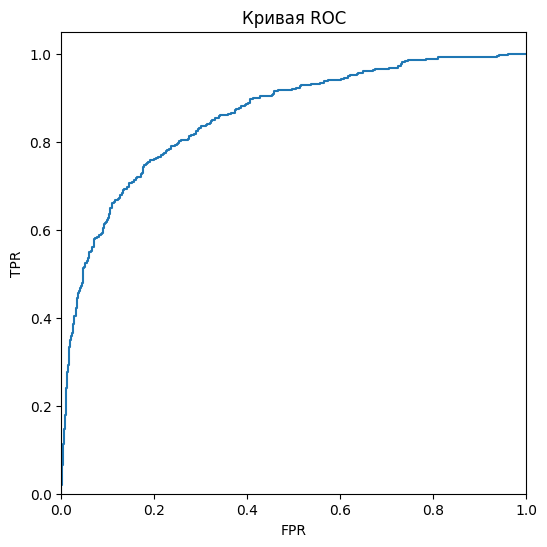

In [42]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure(figsize=(6, 6))
plt.step(fpr, tpr, where='post')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая ROC')
plt.show()

In [43]:
# Для сравнения посчитаем F1-меру константной модели, которая по каждому клиенту прогнозирует уход в ближайшее время
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train_ohe_scaled, target_train)
f1_score(dummy_model.predict(features_test_ohe_scaled), target_test)

0.3235023041474654

F1-мера константной модели существенно хуже, чем у полученной модели.

In [44]:
# Определим recall полученной модели
print('Полученная модель правильно определяет ~ ', round(100*recall_score(target_test, predicted_forest_test), 1),
      ' % клиентов на отток.', sep='')

Полученная модель правильно определяет ~ 64.4 % клиентов на отток.


Общий вывод:
- на этапе подготовки данных удалили нерелевантные признаки и часть объектов с пропусками,
- перед обучением моделей выполнили прямое кодирование категориальных признаков и масштабирование числовых признаков,
- применили для решения задачи несколько моделей, а также различные способы борьбы с дисбалансом классов,
- удалось добиться целевого значения метрики качества F1-мера,
- при выборе наилучшей модели дополнительно определялась метрика AUC-ROC,
- для наилучшей модели построена ROC-кривая,
- выполнено сравнение выбранной модели с константной, показатель качества F1-мера константной модели существенно ниже, чем у модели,
- полученная модель на тестовой выборке позволила достигнуть целевого значения метрики качества F1-мера и корректно определила более 64% клиентов на отток.